In [24]:
import os
import netCDF4  #prevent hdf stray error because of multiple imports of libraries dealing with hdf5

from pyDTDM import *
import warnings
import yaml
try:
    from yaml import Cloader as Loader
except ImportError:

    from yaml import Loader
import ptt
import shapely
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

from geopy import Point as GeopyPoint
import cmcrameri.cm as cmc

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches



### Load Configuration Parameters

This block reads model parameters from the YAML configuration file (`InputFile.yaml`).  
- `yaml.load()` loads all key–value pairs into the dictionary `PARAMS`, which will be used throughout the workflow.  
- Printing the separator lines makes it easier to visually confirm that the configuration has been successfully loaded.  


In [2]:
config_file="InputFile.yaml"
with open(config_file) as f:
    PARAMS = yaml.load(f, Loader=Loader)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(" Parameters set from %s" % config_file)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
 Parameters set from InputFile.yaml
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Define Input Files and Model Parameters

This block extracts paths and parameter values from the configuration file (`InputFile.yaml`) and prepares them for use in the workflow.

**Plate model inputs**
- `MODEL_NAME`: name of the plate kinematic model.  
- `MODEL_DIR`: directory containing the plate model data.  
- `topology_filenames` & `rotation_filenames`: lists of input files for plate topologies and plate rotations.  
- `agegrid`: path to the age grid file.  
- `coastlines`, `continents`, `static_polygons`: geographic reference data for the model setup.

** Slab geometry inputs (from SLAB2 model)**
- `SLAB_DEP`: slab depth grid.  
- `SLAB_DIP`: slab dip grid.  
- `SLAB_THK`: slab thickness grid.  

**Reference frames and mesh setup**
- `Paleomag_ID`: paleomagnetic reference frame ID.  
- `Mantle_ID`: mantle-optimised reference frame ID.  
- `MESH_REFINEMENT_LEVEL`: controls resolution of crustal points (higher refinement → finer spacing but slower runtime).  

**Grid and compression parameters**  ## this is not used
- `NETCDF_GRID_RESOLUTION`: spatial resolution of the output grid (degrees).  
- `ZLIB` and `COMPLEVEL`: NetCDF compression options.  

**Time parameters**
- `FROM_TIME`, `TO_TIME`, `TIME_STEPS`: maximum, minimum, and step size for model time (in Myr).  

**Parallelisation**. ## this is not used
- `parallel`: number of CPU cores to use (set to `None` for single core, `-1` to use all available cores).  

At the end, the script prints a summary of the loaded parameters, which serves as a quick check before running the model.


In [3]:
# Input Files 
MODEL_NAME=PARAMS['InputFiles']['plate_kinematics']['model_name'] # model name
MODEL_DIR = PARAMS['InputFiles']['plate_kinematics']['model_dir']  ## plate model location
topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['topology_files']]
rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['rotation_files']]
agegrid=PARAMS['InputFiles']['plate_kinematics']['agegrid'] ## agegrid location
coastlines = f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['coastline_file']}"
static_polygon_file=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['static_polygon']}"
static_polygons = pygplates.FeatureCollection(static_polygon_file)
continents=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['continents']}"



SLAB_DEP=PARAMS['InputFiles']['Raster']['SLAB2_DEP'] # SLAB2 grid depth
SLAB_DIP=PARAMS['InputFiles']['Raster']['SLAB2_DIP'] # SLAB2 grid dip
SLAB_THK=PARAMS['InputFiles']['Raster']['SLAB2_DIP'] # SLAB2 grid thickness

print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Plate Model: {MODEL_NAME} \n")
print(f"Model Directory: {MODEL_DIR} \n")
print(f"Coastlines: {coastlines} \n")
print(f"Continents: {continents} \n")
print(f"Static Polygons: {static_polygon_file} \n")
print(f"Model Agegrid: {agegrid} \n")
print(f"Slab depth grid: {SLAB_DEP}")
print(f"Slab dip grid: {SLAB_DIP}")
print(f"Slab thickness grid: {SLAB_THK}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

Paleomag_ID=PARAMS['Parameters']['paleomag_id']
Mantle_ID=PARAMS['Parameters']['mantle_optimised_id']

#The initial positions of crustal points are evenly distributed within the designated region. 
# At mesh refinement level zero, the points are approximately 20 degrees apart.
# Each increase in the density level results in a halving of the spacing between points.
MESH_REFINEMENT_LEVEL=PARAMS['Parameters']['mesh_refinement_level']  # higher refinement level will take longer time to run for optimisation 

NETCDF_GRID_RESOLUTION=PARAMS['GridParameters']['grid_spacing']  # in degree
ZLIB=PARAMS['GridParameters']['compression']['zlib'] 
COMPLEVEL=PARAMS['GridParameters']['compression']['complevel'] 

FROM_TIME=int(PARAMS['TimeParameters']['time_max'])
TO_TIME=int(PARAMS['TimeParameters']['time_min'])
TIME_STEPS=int(PARAMS['TimeParameters']['time_step'])




n_jobs=PARAMS['Parameters']['number_of_cpus']### No of core to use or None for single core


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("The following parameters are set-")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Optmised Reference Frame ID: {Mantle_ID}")
print(f"Paleomagnetic Reference Frame ID: {Paleomag_ID} \n")


print(f"Mesh Refinement Level: {MESH_REFINEMENT_LEVEL}")
print(f"NetCDF GRID Resolution: {NETCDF_GRID_RESOLUTION}")
print(f"NetCDF Compression Level: {COMPLEVEL} \n")
print(f"Model Start Time: {FROM_TIME}")
print(f"Model End Time: {TO_TIME}")
print(f"Model Time Step: {TIME_STEPS}\n")


print(f"Number of CPU: {n_jobs}") # -1 means all the freely available CPU


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Plate Model: Zahirovic_etal_2022_GDJ_NNR 

Model Directory: /Volumes/Satyam/pyDTDM_EBMWorkflow/PlateReconstruction/ 

Coastlines: /Volumes/Satyam/pyDTDM_EBMWorkflow/PlateReconstruction//StaticGeometries/Coastlines/Global_coastlines_low_res.shp 

Continents: /Volumes/Satyam/pyDTDM_EBMWorkflow/PlateReconstruction//StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons.shp 

Static Polygons: /Volumes/Satyam/pyDTDM_EBMWorkflow/PlateReconstruction//StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp 

Model Agegrid: /Volumes/Satyam/pyDTDM_EBMWorkflow/PlateReconstruction/SeafloorAgegrid 

Slab depth grid: /Volumes/Satyam/pyDTDM_EBMWorkflow/PlateReconstruction/Rasters/Slab2/Slab2_compiled_dep.nc
Slab dip grid: /Volumes/Satyam/pyDTDM_EBMWorkflow/Pl

### Define Output Directories

This block sets up the folders where model results will be saved:  

- `OUTPUT_FOLDER`: main output directory specified in the configuration file.  
- `DEFAULT_OUTPUT_CSV`: stores tabular results (CSV format).  
- `DEFAULT_OUTPUT_GRID`: stores gridded results (NetCDF format).  
- `DEFAULT_OUTPUT_FIGURE`: stores plots and figures.  

The function `create_directory_if_not_exists()` ensures that each of these directories exists before the model runs (creates them if they don’t).  

Finally, a message is printed confirming the main output path.


In [4]:
# Output Directory
OUTPUT_FOLDER=PARAMS['OutputFiles']['output_dir']

DEFAULT_OUTPUT_CSV=os.path.join(OUTPUT_FOLDER,'CSV')  # folder to store output in Tabular format
DEFAULT_OUTPUT_GRID=os.path.join(OUTPUT_FOLDER,'GRID') # folder to store output NetCDF grid
DEFAULT_OUTPUT_FIGURE=os.path.join(OUTPUT_FOLDER,'FIGURE')




print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"All the output will be saved in {OUTPUT_FOLDER}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
create_directory_if_not_exists(OUTPUT_FOLDER)
create_directory_if_not_exists(DEFAULT_OUTPUT_CSV)
create_directory_if_not_exists(DEFAULT_OUTPUT_GRID)
create_directory_if_not_exists(DEFAULT_OUTPUT_FIGURE)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
All the output will be saved in /Volumes/SatyamData/WorkflowSlabGeometry/Slab2_Results
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Load SLAB2 Grids and Convert to GeoTIFF

This block handles the subduction zone inputs from the SLAB2 model:  

- `slab_dep`, `slab_dip`, `slab_thickness`: load the slab depth, dip, and thickness grids as **xarray DataArrays** for easy manipulation.  

To make the data more portable and compatible with workflows, the script converts the original NetCDF grids into **GeoTIFF format**:  
- `nc_paths`: list of input NetCDF files.  
- `tiff_paths`: corresponding output GeoTIFF file paths (saved in the `GRID` output directory).  
- `nc_to_tiff()`: helper function used to perform the NetCDF → GeoTIFF conversion.  




In [5]:
### loading the slab 2 grid as dataarray

slab_dep=xr.open_dataarray(SLAB_DEP)
slab_dip=xr.open_dataarray(SLAB_DIP)
slab_thickness=xr.open_dataarray(SLAB_THK)
# We will convert the Slab2 netcdf to  
# 
# Define input NetCDF paths
nc_paths = [SLAB_DEP, SLAB_DIP, SLAB_THK ]

tiff_paths = [f"{DEFAULT_OUTPUT_GRID}/Slab2_compiled_dep.tif",f"{DEFAULT_OUTPUT_GRID}/Slab2_compiled_dip.tif", f"{DEFAULT_OUTPUT_GRID}/Slab2_compiled_thk.tif"]

for i in range(len(nc_paths)):
    nc_to_tiff(nc_paths[i],tiff_paths[i])

Conversion Complete
Conversion Complete
Conversion Complete


### Extract Trenches from Plate Tectonic Reconstruction

In this step, trenches are extracted from a global plate tectonic reconstruction.  
The workflow uses the **PlateKinematicsParameters** class to read the input plate model data (topologies, rotations, polygons, agegrid, coastlines, continents).  

- `get_subductiondf()` generates a dataframe of trench points for a given reconstruction time.  
- The trenches are discretized at the resolution specified in the YAML file (`NETCDF_GRID_RESOLUTION`).  

From these trench geometries, additional kinematic parameters can later be calculated, such as:  
- trench migration rate,  
- subduction volume rate,  
- thickness of the subducting plate, etc.  

The script prints the number of trench points extracted at time = 0 Ma, which provides a quick check of the reconstruction.


In [6]:
## Plot Slab Geometry Cross Section
PK=PlateKinematicsParameters(topology_filenames, ## all the plate topologies files (as list of str)
                             rotation_filenames, ### all the rotation files (as list of str)
                             static_polygons,  ### as str
                             agegrid=agegrid,  ### folder containing all the agegrid (as .nc)
                             coastlines=coastlines, ## str
                             continents=continents, ## st
                             anchor_plate_id=Mantle_ID) ## int



In [7]:
subduction_df=PK.get_subductiondf(reconstruction_time=0,tessellation_threshold_deg=NETCDF_GRID_RESOLUTION)
print(f"Number of trench point: {len(subduction_df)}")

Using agegrid file : /Volumes/Satyam/pyDTDM_EBMWorkflow/PlateReconstruction/SeafloorAgegrid/agegrid_final_mask_0Ma.nc
Number of trench point: 6238


### Create Profiles Orthogonal to the Trench

This step constructs profiles on the overriding plate, oriented in the **direction of plate convergence** (perpendicular to the trench).  

- `n_segs`: number of trench segments extracted from the reconstruction.  
- `n_steps`: number of points along each profile (defines profile length).  
- `dres`: angular spacing (in radians) between consecutive points along the profile (controls resolution).  

For each trench point:  
1. Compute offsets in longitude (`dlon`) and latitude (`dlat`) using the **subduction normal angle**.  
2. Extend the profile step-by-step into the overriding plate.  
3. Store the profile coordinates (`lats`, `lons`) and labels (`Profiles`).  

Finally, the arrays of longitude, latitude, and profile IDs are flattened for easier downstream use (e.g., mapping, sampling slab grids along these profiles).  

This provides the spatial framework to later extract slab geometry cross-sections orthogonal to subduction zones.


In [8]:
n_segs = len(subduction_df['Trench Longitude'])
n_steps = 500 
dres = np.radians(2) ## you can set resolution here
lats=np.zeros((n_steps,n_segs))
lons=np.zeros((n_steps,n_segs))

Profiles=[]
for i in range(1, n_steps):
    dlon = dres*i*np.sin(np.radians(subduction_df['Subduction Normal Angle']))
    dlat = dres*i*np.cos(np.radians(subduction_df['Subduction Normal Angle']))
    
    ilon = subduction_df['Trench Longitude'] + dlon
    ilat = subduction_df['Trench Latitude'] + dlat
   
    profile=[f"Profile {j}" for j in range(0,len(ilon))]
    
    lats[i]=ilat
    lons[i]=ilon
    Profiles.append(profile)

    

lons=lons[1:].reshape(-1)
lats=lats[1:].reshape(-1)


Profiles = [item for sublist in Profiles for item in sublist]


In [9]:
#create a dataframe with profile
profile_df=pd.DataFrame({'Longitude':lons,'Latitude':lats, "Profile Name": Profiles})
profile_gdf=gpd.GeoDataFrame(profile_df, geometry=gpd.points_from_xy(profile_df['Longitude'],profile_df['Latitude']))

<GeoAxes: >

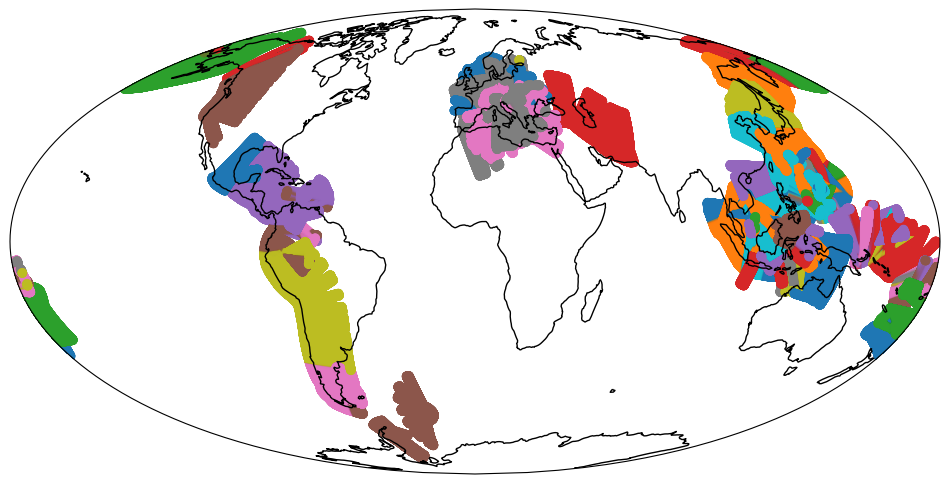

In [14]:
proj = ccrs.Mollweide(central_longitude=0)

fig = plt.figure(figsize=(12,8), dpi=100)
ax = plt.axes(projection=proj)
ax.set_global()

ax.coastlines()
profile_gdf.plot(ax=ax,column='Profile Name',transform=ccrs.PlateCarree())

# Extracting Slab Geometry Information Along Profiles

This step samples slab geometry values (depth, dip, thickness) from the **GeoTIFF grids** at each profile point:  

1. Load the slab GeoTIFFs with `rasterio`.  
2. Generate `Point` geometries for all profile coordinates (`lons`, `lats`).  
3. Use `rasterio.sample()` to extract pixel values for each point.  
4. Store the extracted values in a `GeoDataFrame` (`slab_df`) containing:  
   - slab depth, dip, thickness,  
   - geographic coordinates,  
   - profile name,  
   - point geometry.  

Finally, a **geodesic distance column** (in km) is computed for each profile relative to its trench point.  
Here we use `joblib` to parallelize the distance calculation across all profiles for faster execution.


In [10]:

## first we read all the tiff
slab_dep_tiff=rasterio.open(f"{DEFAULT_OUTPUT_GRID}/Slab2_compiled_dep.tif")
slab_dip_tiff=rasterio.open(f"{DEFAULT_OUTPUT_GRID}/Slab2_compiled_dip.tif")
slab_thickness_tiff=rasterio.open(f"{DEFAULT_OUTPUT_GRID}/Slab2_compiled_thk.tif")


values_slab_dep = []
values_slab_dip= []
values_slab_thickness= []

point_geometries = [Point(lons[i], lats[i]) for i in range(len(lats))]

# Convert the list of geometries to a geopandas GeoSeries
point_series = gpd.GeoSeries(point_geometries)

# Extract pixel values at the projected coordinates using the sample function
values_slab_dep = list(slab_dep_tiff.sample([(geom.x, geom.y) for geom in point_series.geometry]))
values_slab_dip= list(slab_dip_tiff.sample([(geom.x, geom.y) for geom in point_series.geometry]))
values_slab_thickness = list(slab_thickness_tiff.sample([(geom.x, geom.y) for geom in point_series.geometry]))

## create a dataframe of all the parameters
slab_df = gpd.GeoDataFrame({'Slab Depth': [value[0] for value in values_slab_dep],
                       'Slab Dip':[value[0] for value in values_slab_dip],
                       'Slab Thickness':[value[0] for value in values_slab_thickness],
                       'Latitude': lats,
                       'Longitude': lons,
                       'Profile Name': Profiles,
                       'geometry':point_series })



In [11]:
# from joblib import Parallel, delayed

# # --- Existing slab_df creation code stays the same up to here ---

# def compute_profile_distances(profile_name):
#     """Compute geodesic distances for one profile."""
#     slab_df_profile = slab_df[slab_df['Profile Name'] == profile_name].reset_index(drop=True)
#     reference_point = (slab_df_profile.loc[0, "Latitude"], slab_df_profile.loc[0, "Longitude"])
    
#     slab_df_profile["Distance_km"] = slab_df_profile.apply(
#         lambda row: geodesic(reference_point, (row["Latitude"], row["Longitude"])).kilometers,
#         axis=1
#     )
#     return slab_df_profile

# # Get all unique profiles
# profile_names = slab_df['Profile Name'].unique()

# # Run in parallel across profiles
# results = Parallel(n_jobs=n_jobs)(delayed(compute_profile_distances)(p) for p in profile_names)

# # Concatenate results into one dataframe
# slab_df = gpd.GeoDataFrame(pd.concat(results, ignore_index=True))


In [ ]:
slab_gdf = gpd.GeoDataFrame( slab_df, geometry=gpd.points_from_xy(slab_df.Longitude, slab_df.Latitude), crs="EPSG:4326" )

# Get first points of each profile as reference points
refs = slab_gdf.groupby('Profile Name').first().reset_index()

# Repeat the reference points to match the length of each profile
refs_expanded = slab_gdf[['Profile Name']].merge(refs, on='Profile Name', how='left')

# Now use sjoin_nearest_geodesic_points with slab_gdf and refs_expanded
slab_df = sjoin_nearest_geodesic_points(
    slab_gdf, 
    gpd.GeoDataFrame(refs_expanded, geometry=gpd.points_from_xy(refs_expanded.Longitude, refs_expanded.Latitude), crs="EPSG:4326"),
    k=1, 
    distance_col='Distance_km'
)

slab_df['Distance_km'] /= 1000


In [23]:
### save it as csv file
slab_df.to_csv(f"{DEFAULT_OUTPUT_CSV}/AllExtractedSlabData.csv")

In [ ]:
slab_df=pd.read_csv(f"{DEFAULT_OUTPUT_CSV}/AllExtractedSlabData.csv")

## Plotting a profile

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


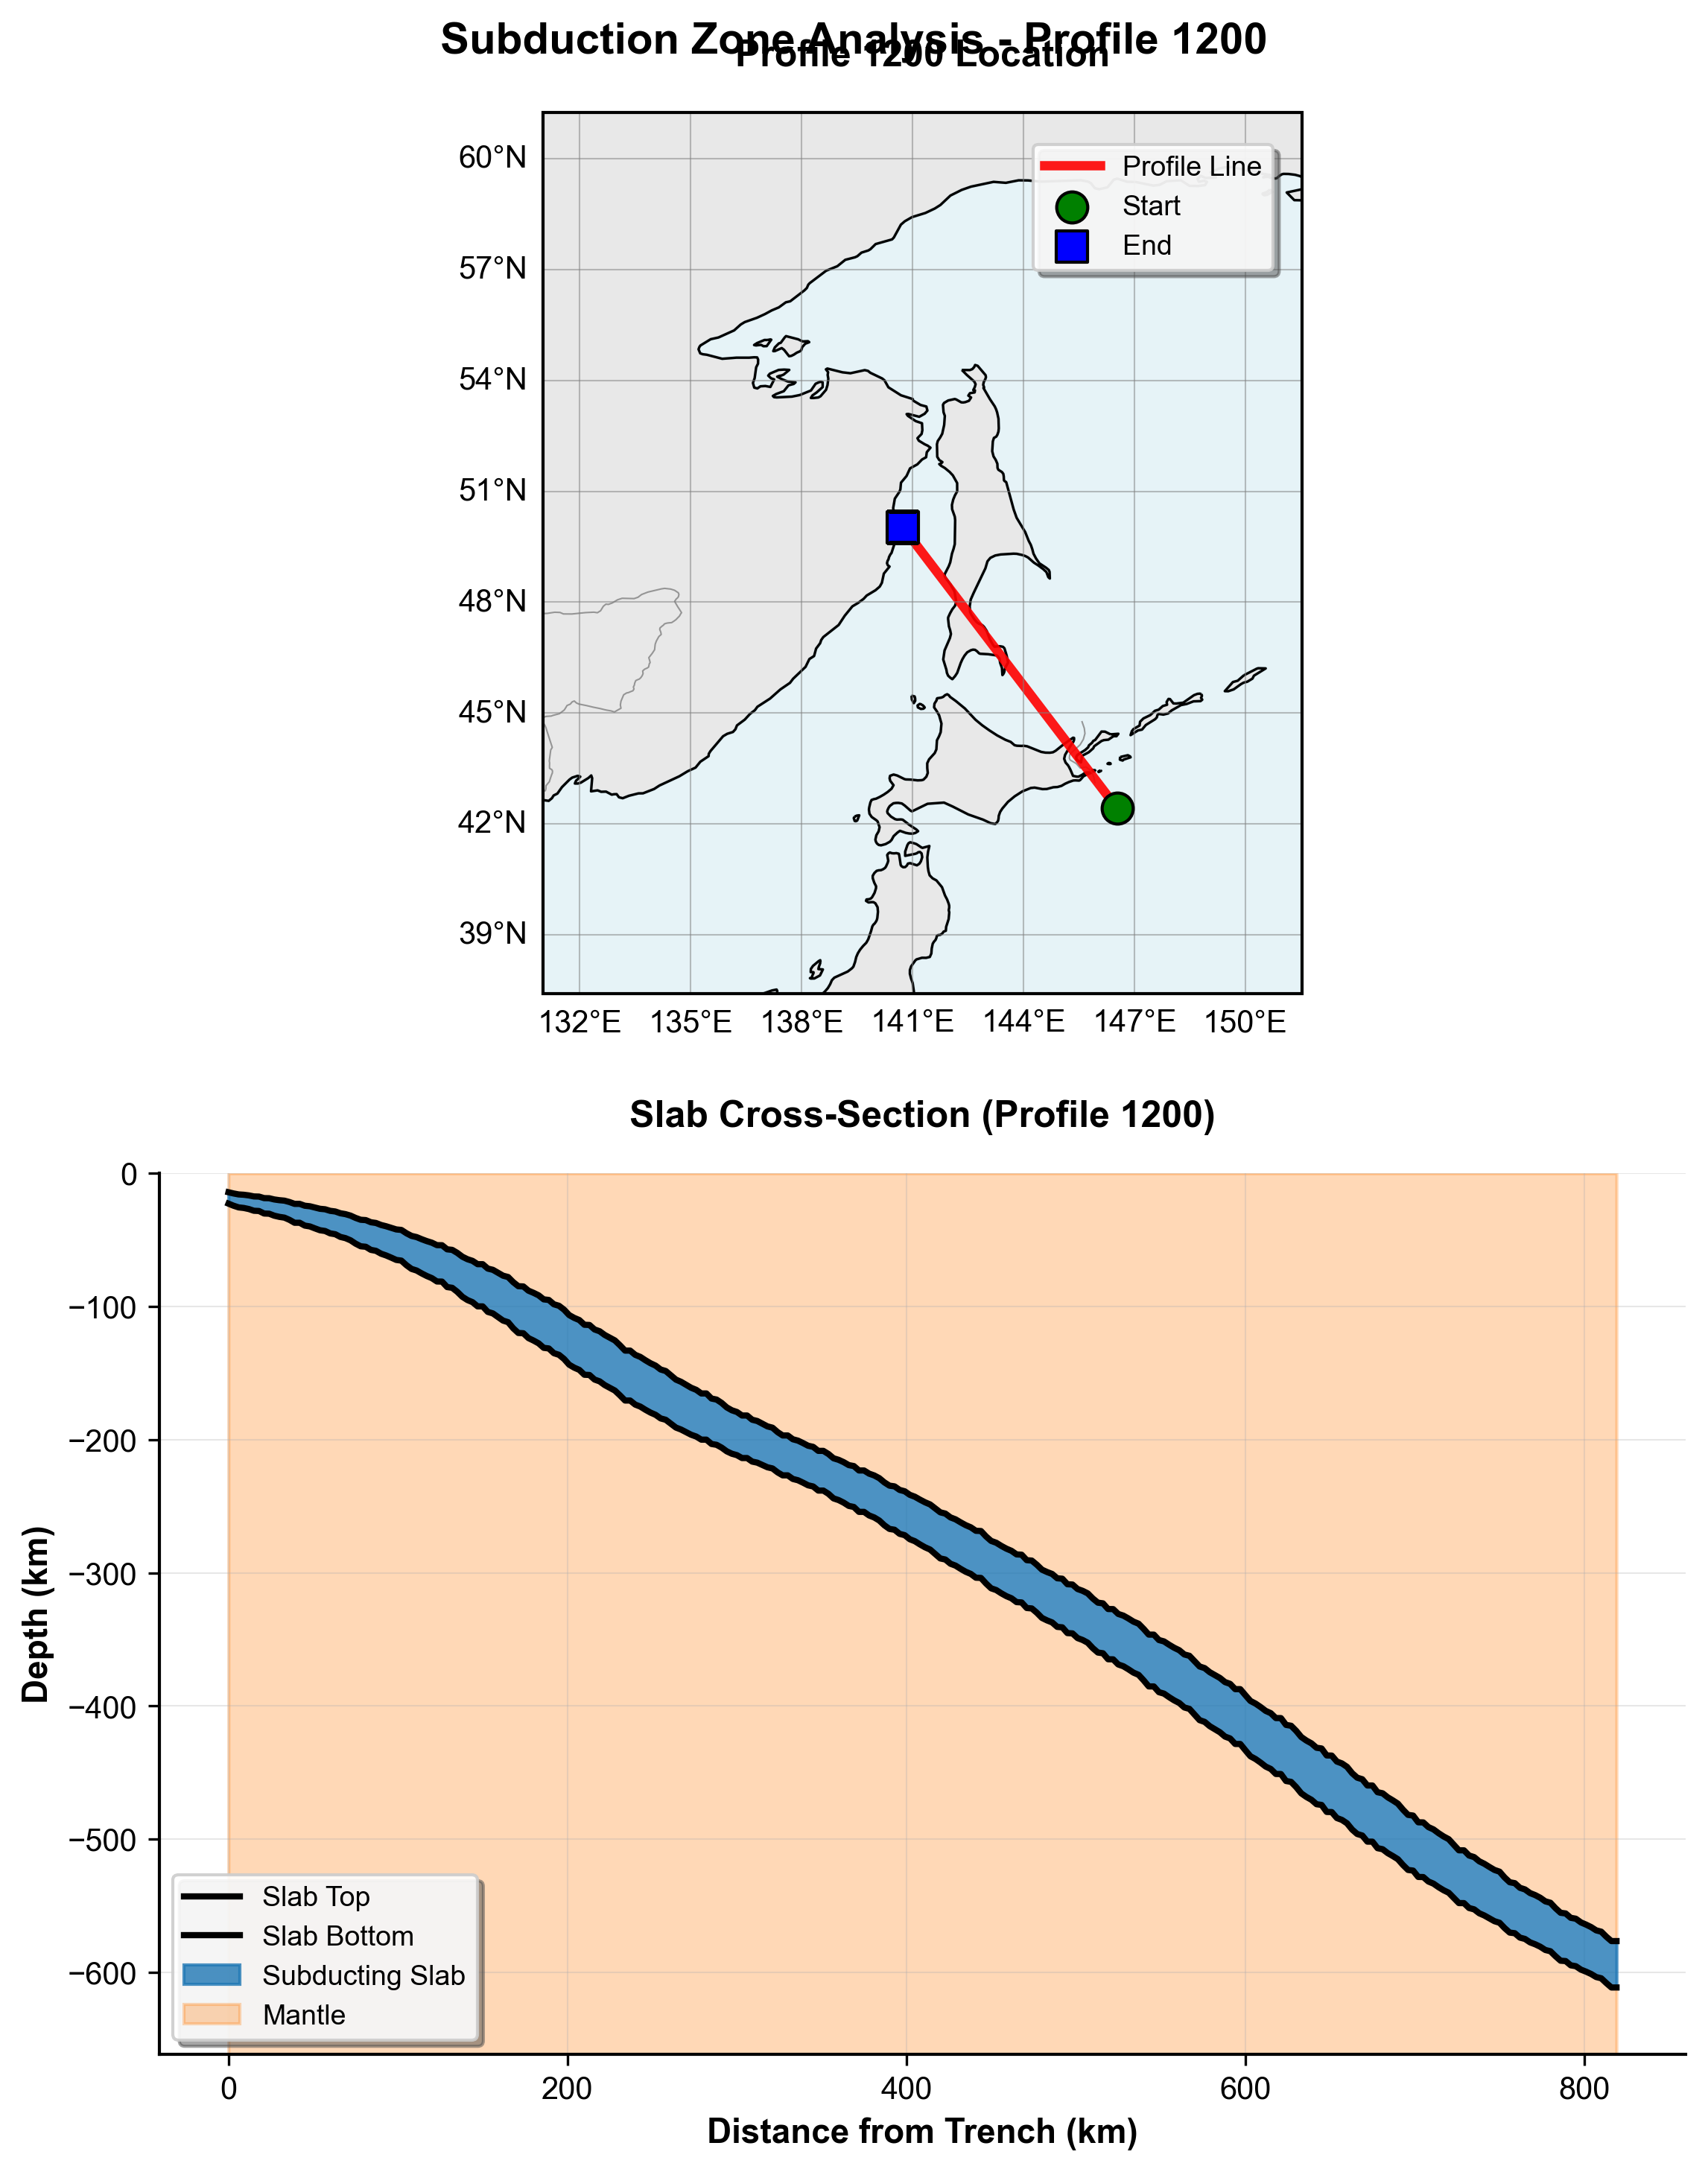

In [35]:
## plotting profile 
n=1200


slab_df_profile = slab_df[slab_df['Profile Name'] == f'Profile {n}']
slab_df_profile = slab_df_profile.reset_index(drop=True)

# Sort by Distance_km
df = slab_df_profile.sort_values(by="Distance_km")

# Define new consistent distance grid
distance_min = df["Distance_km"].min()
distance_max = df["Distance_km"].max()
new_distances = np.arange(distance_min, distance_max + 3, 3)

# Interpolate columns onto new grid
df_interp = pd.DataFrame({"Distance_km": new_distances})
df_interp["Slab Depth"] = np.interp(new_distances, df["Distance_km"], df["Slab Depth"])
df_interp["Slab Dip"] = np.interp(new_distances, df["Distance_km"], df["Slab Dip"])
df_interp["Slab Thickness"] = np.interp(new_distances, df["Distance_km"], df["Slab Thickness"])

# Find valid data indices
not_nan_mask = df_interp["Slab Depth"].notna()
valid_indices = np.where(not_nan_mask)[0]

if len(valid_indices) > 0:
    start = valid_indices[0]

    if df_interp.loc[start, "Distance_km"] <= 200:
        # Find where the first break occurs
        for i in range(start + 1, len(df_interp)):
            if pd.isna(df_interp.loc[i, "Slab Depth"]):
                end = i
                break
        else:
            end = len(df_interp)
    else:
        end = 0

# Filter DataFrame
df_interp = df_interp.iloc[:end]

if not df_interp["Slab Depth"].isna().all():
    df_interp.to_csv(f"{DEFAULT_OUTPUT_CSV}/ExtractedSlabData/Slab2/Slab_profile_{n}.csv", index=False)
    
    x = df_interp["Distance_km"]
    depth = df_interp["Slab Depth"]
    bottom = depth - df_interp["Slab Thickness"]

    # Create publication-ready figure
    fig = plt.figure(figsize=(8, 10), dpi=300)
    
    # =========================
    # TOP PANEL: Map view
    # =========================
    proj = ccrs.PlateCarree()
    ax1 = fig.add_subplot(2, 1, 1, projection=proj)
    
    # Set map extent based on data bounds with padding
    lon_min, lon_max = slab_df_profile['Longitude'].min(), slab_df_profile['Longitude'].max()
    lat_min, lat_max = slab_df_profile['Latitude'].min(), slab_df_profile['Latitude'].max()
    
    # Add padding (5 degrees)
    padding = 5
    ax1.set_extent([lon_min - padding, lon_max + padding, 
                    lat_min - padding, lat_max + padding], crs=ccrs.PlateCarree())
    
    # Add map features with high quality
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
    ax1.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
    ax1.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray', alpha=0.8)
    
    # Plot profile line with enhanced styling
    profile_line = ax1.plot(slab_df_profile['Longitude'][:end], slab_df_profile['Latitude'][:end], 
                            color='red', linewidth=3, alpha=0.9, 
                            transform=ccrs.PlateCarree(), label='Profile Line')
    
    # Add start and end markers
    ax1.scatter(slab_df_profile['Longitude'].iloc[0], slab_df_profile['Latitude'].iloc[0],
                s=100, c='green', marker='o', transform=ccrs.PlateCarree(), 
                zorder=10, edgecolor='black', linewidth=1, label='Start')
    ax1.scatter(slab_df_profile['Longitude'].iloc[end], slab_df_profile['Latitude'].iloc[end],
                s=100, c='blue', marker='s', transform=ccrs.PlateCarree(), 
                zorder=10, edgecolor='black', linewidth=1, label='End')
    
    # Add gridlines
    gl = ax1.gridlines(draw_labels=True, alpha=0.5, linewidth=0.5, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    
    # Add title and legend
    ax1.set_title(f'Profile {n} Location', fontsize=12, fontweight='bold', pad=15)
    legend = ax1.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), 
                        frameon=True, fancybox=True, shadow=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # =========================
    # MIDDLE PANEL: Cross-section
    # =========================
    ax2 = fig.add_subplot(2, 1, 2)
    
    # Define colors
    slab_color = '#1f77b4'  # Professional blue
    mantle_color = '#ff7f0e'  # Orange for above slab
    # mantle_color = '#2ca02c'  # Green for mantle
    
    # Plot slab boundaries with smooth lines
    top_line = ax2.plot(x, depth, color='black', linewidth=2, 
                        label='Slab Top', zorder=5)
    bottom_line = ax2.plot(x, bottom, color='black', linewidth=2, 
                            label='Slab Bottom', zorder=5)
    
    # Fill regions with professional colors
    ax2.fill_between(x, 0, depth, color=mantle_color, alpha=0.3, zorder=1)
    ax2.fill_between(x, depth, bottom, color=slab_color, alpha=0.8, 
                    label='Subducting Slab', zorder=2)
    ax2.fill_between(x, bottom, bottom.min() - 50, color=mantle_color, alpha=0.3, 
                    label='Mantle', zorder=1)
    
    # Enhance axes
    ax2.set_ylabel('Depth (km)', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Distance from Trench (km)', fontsize=11, fontweight='bold')
    # ax2.invert_yaxis()  # Depth increases downward
    
    # Set reasonable y-limits
    y_min = max(0, depth.min() - 20)
    y_max = min(bottom.min() - 50, -50)
    ax2.set_ylim(y_max, y_min)
    
    # Add grid
    ax2.grid(True, alpha=0.3, linewidth=0.5)
    
    # Add legend
    legend2 = ax2.legend(loc='lower left', frameon=True, fancybox=True, shadow=True)
    legend2.get_frame().set_facecolor('white')
    legend2.get_frame().set_alpha(0.9)
    
    # Add title
    ax2.set_title(f'Slab Cross-Section (Profile {n})', fontsize=12, fontweight='bold', pad=15)
    

    # =========================
    # Final adjustments
    # =========================
    
    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)
    
    # Add overall figure title
    fig.suptitle(f'Subduction Zone Analysis - Profile {n}', 
                fontsize=14, fontweight='bold', y=0.98)
    
    # Save with high quality
    plt.savefig(f"{DEFAULT_OUTPUT_FIGURE}/Profile_{n}_publication.png", 
                dpi=300, bbox_inches='tight', facecolor='white', 
                edgecolor='none', format='png')
    
    # Also save as PDF for vector graphics
    plt.savefig(f"{DEFAULT_OUTPUT_FIGURE}/Profile_{n}_publication.pdf", 
                bbox_inches='tight', facecolor='white', 
                edgecolor='none', format='pdf')
    
    # plt.close()
    
    # print(f"✓ Profile {n}: Publication-ready figures saved successfully")
    

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 0: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 1: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 2: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 3: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 4: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 5: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 6: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 7: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 8: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 9: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 10: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 11: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 12: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 13: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 14: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 15: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 16: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 17: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 18: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 19: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 20: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 21: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 22: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 23: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 24: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 25: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 26: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 27: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 28: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 29: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 30: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 31: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 32: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 33: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 34: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 35: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 36: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 37: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 38: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 39: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 40: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 41: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 42: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 43: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 44: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 45: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 46: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 47: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 48: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 49: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 50: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 51: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 52: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 53: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 54: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 55: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 56: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 57: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 58: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 59: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 60: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 61: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 62: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 63: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 64: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 65: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 66: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 67: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 68: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 69: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 70: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 71: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 72: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 73: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 74: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 75: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 76: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 77: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 78: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 79: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 80: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 81: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 82: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 83: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 84: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 85: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 86: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 87: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 88: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 89: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 90: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 91: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 92: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 93: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 94: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 95: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 96: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 97: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 98: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 99: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 100: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 101: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 102: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 103: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 104: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 105: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 106: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 107: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 108: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 109: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 110: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 111: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 112: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 113: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 114: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 115: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 116: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 117: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 118: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 119: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 120: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 121: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 122: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 123: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 124: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 125: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 126: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 127: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 128: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 129: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 130: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 131: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 132: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 133: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 134: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 135: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 136: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 137: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 138: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 139: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 140: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 141: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 142: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 143: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 144: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 145: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 146: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 147: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 148: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 149: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 150: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 151: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 152: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 153: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 154: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 155: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 156: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 157: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 158: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 159: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 160: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 161: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 162: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 163: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 164: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 165: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip


✓ Profile 166: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 167: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 168: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 169: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 170: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 171: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 172: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 173: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 174: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 175: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 176: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 177: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 178: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 179: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 180: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 181: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 182: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 183: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 184: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 185: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 186: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 187: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 188: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 189: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 190: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 191: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 192: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 193: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 194: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 195: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 196: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 197: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 198: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 199: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 200: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 201: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 202: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 203: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 204: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 205: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 206: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 207: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 208: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 209: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 210: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 211: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 212: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 213: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 214: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 215: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 216: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 217: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 218: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 219: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 220: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 221: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 222: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 223: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 224: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 225: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 226: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 227: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 228: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 229: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 230: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 231: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 232: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 233: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 234: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 235: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 236: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 237: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 238: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 239: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 240: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 241: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 242: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 243: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 244: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 245: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 246: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 247: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 248: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 249: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 250: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 251: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 252: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 253: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 254: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 255: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 256: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 257: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 258: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 259: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 260: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 261: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 262: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 263: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 264: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 265: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 266: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 267: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 268: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 269: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 270: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 271: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 272: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 273: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 274: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 275: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 276: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 277: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 278: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 279: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 280: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 281: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 282: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 283: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 284: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 285: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 286: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 287: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 288: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 289: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 290: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 291: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 292: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 293: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 294: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 295: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 296: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 297: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 298: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 299: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 300: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 301: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 302: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 303: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 304: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 305: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 306: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 307: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 308: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 309: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 310: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 311: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 312: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 313: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 314: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 315: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 316: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 317: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 318: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 319: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 320: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 321: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 322: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 323: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 324: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 325: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 326: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 327: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 328: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 329: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 330: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 331: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 332: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 333: Publication-ready figures saved successfully
⚠ Profile 334: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 335: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 336: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 337: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 338: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 339: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 340: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 341: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 342: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 343: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 344: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 345: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 346: All values in 'Slab Depth' are NaN — not saving t

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 361: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 362: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 363: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 364: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 365: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 366: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 367: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 368: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 369: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 370: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 371: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 372: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 373: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 374: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 375: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 376: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 377: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 378: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 379: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 380: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 381: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 382: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 383: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 384: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 385: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 386: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 387: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 388: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 389: Publication-ready figures saved successfully


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


✓ Profile 390: Publication-ready figures saved successfully
⚠ Profile 391: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 392: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 393: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 394: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 395: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 396: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 397: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 398: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 399: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 400: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 401: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 402: All values in 'Slab Depth' are NaN — not saving the file.
⚠ Profile 403: All values in 'Slab Depth' are NaN — not saving t

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".


ValueError: Axis limits cannot be NaN or Inf

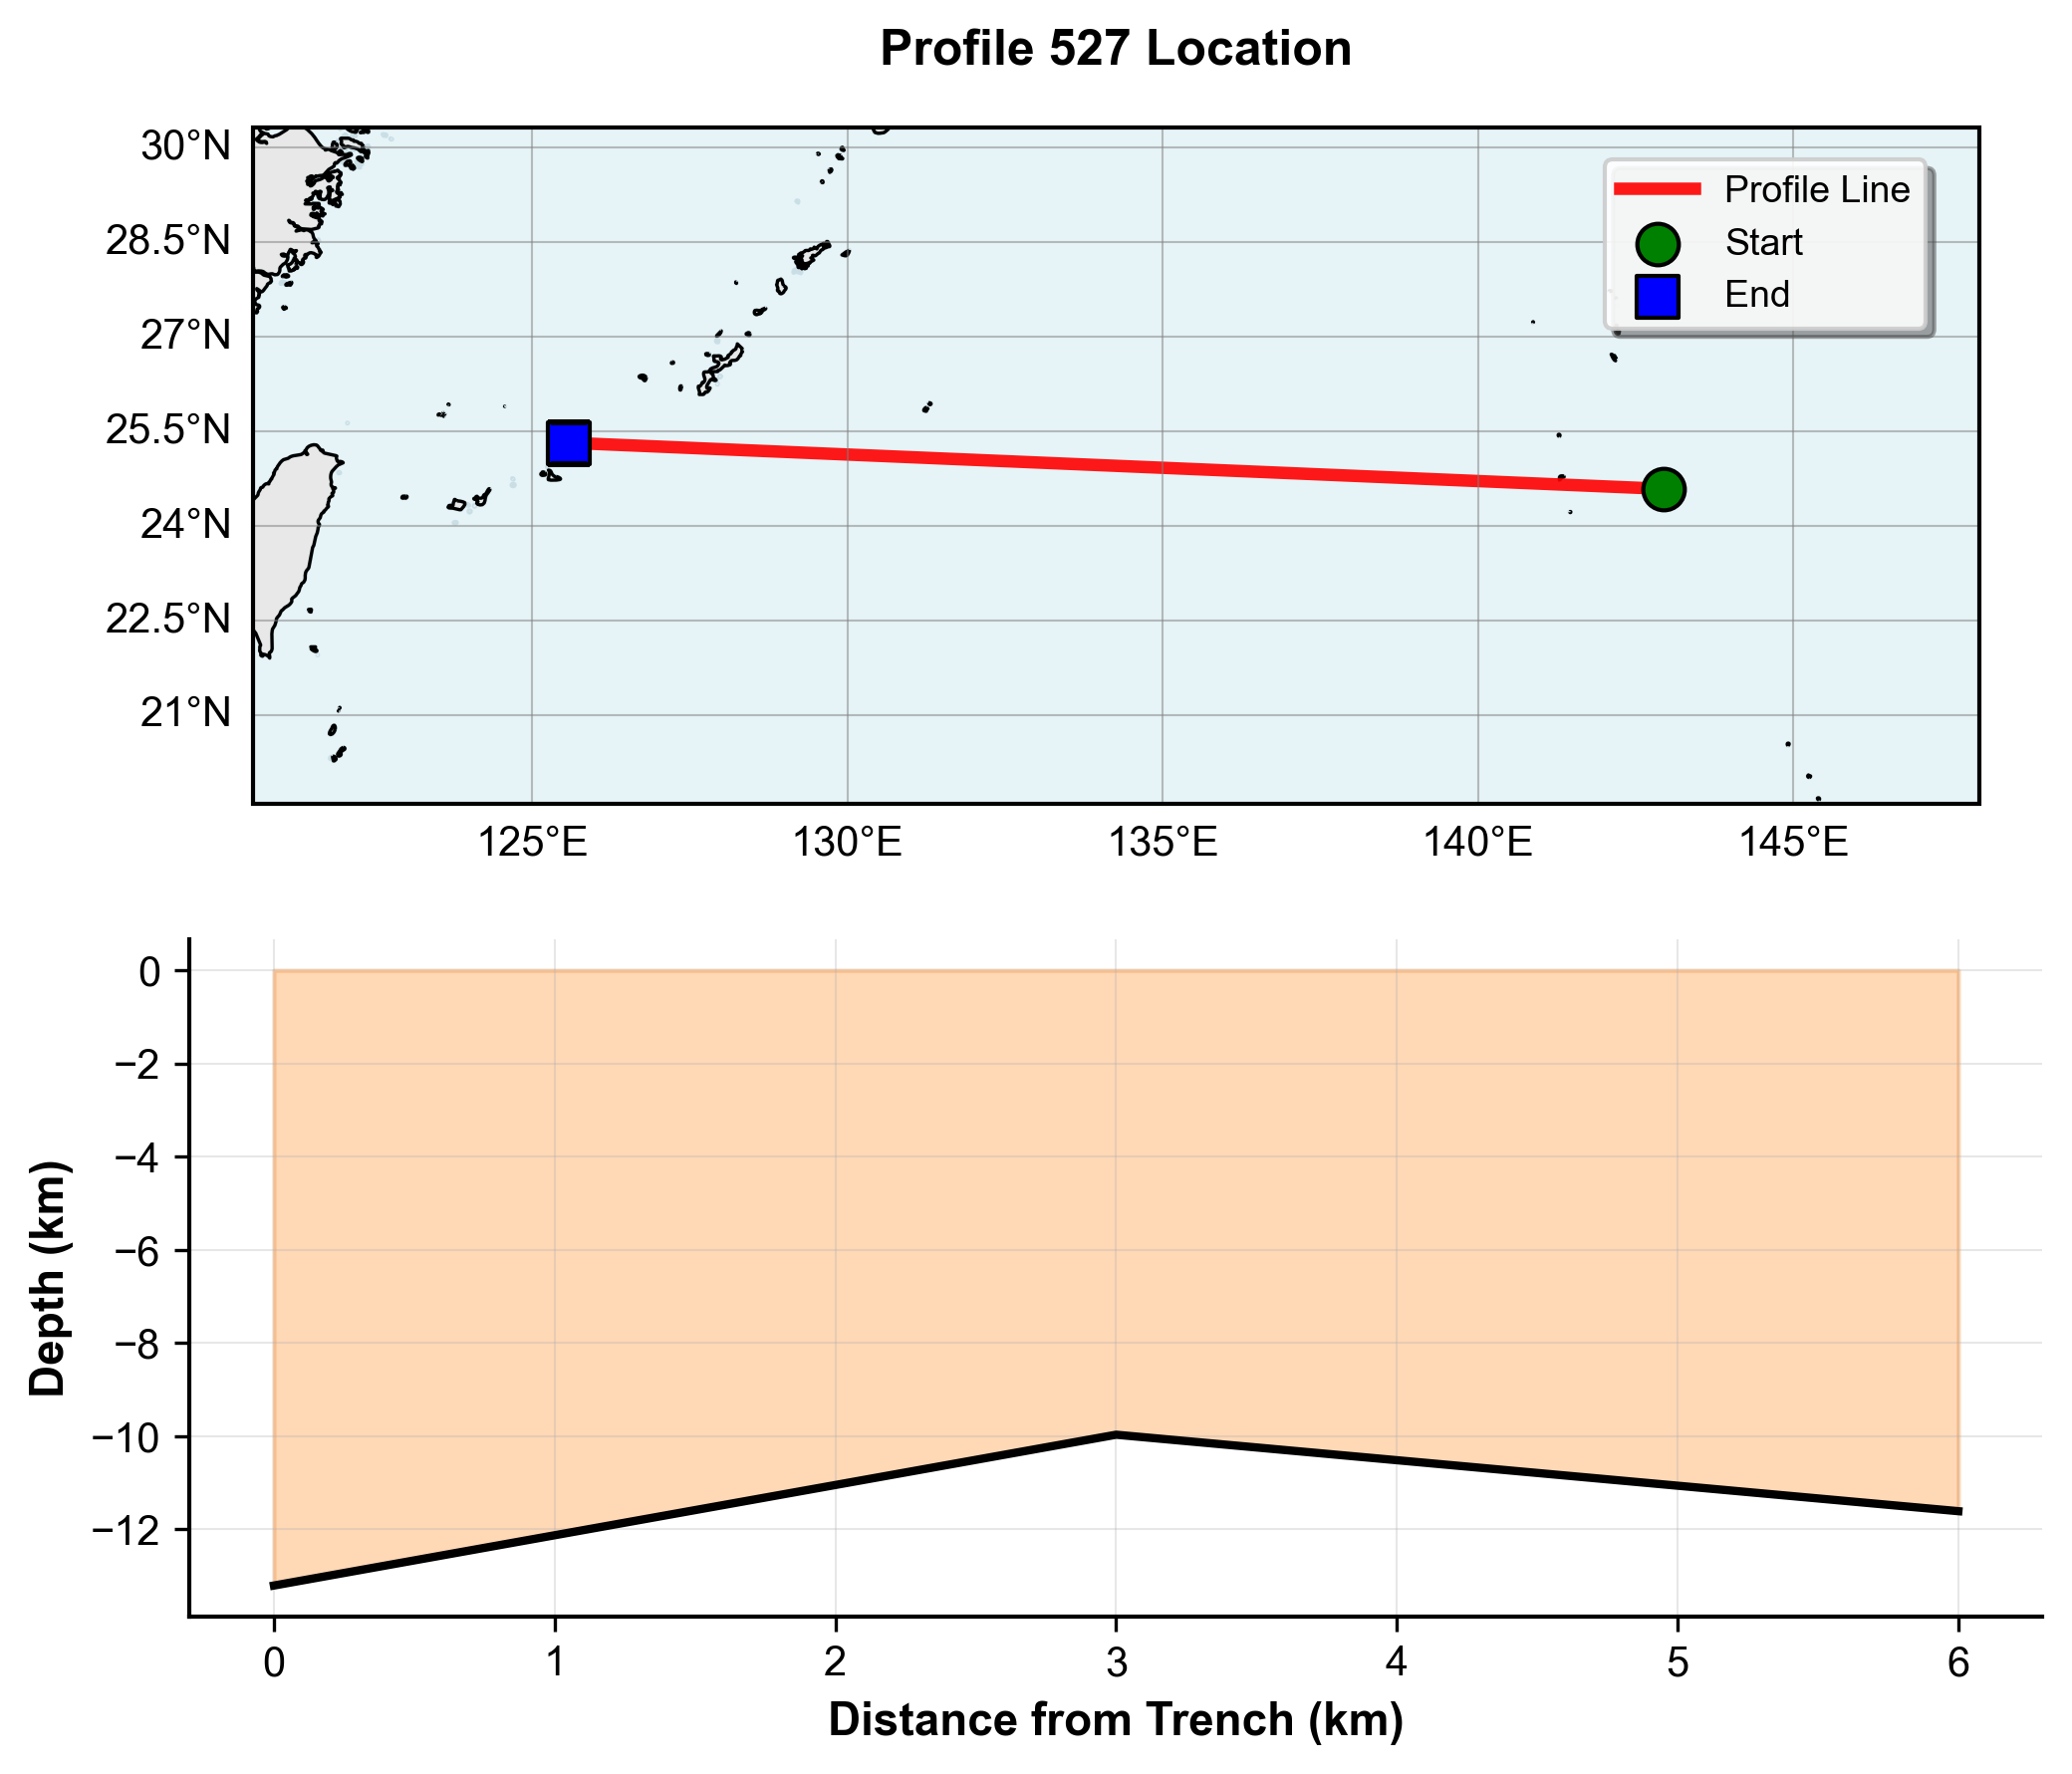

In [ ]:

plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.linewidth': 1.0,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'legend.frameon': False,
    'legend.fontsize': 9,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white'
})

create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/ExtractedSlabData/Slab2")

for n in range(0, len(slab_df['Profile Name'].unique())):
    
    slab_df_profile = slab_df[slab_df['Profile Name'] == f'Profile {n}']
    slab_df_profile = slab_df_profile.reset_index(drop=True)

    # Sort by Distance_km
    df = slab_df_profile.sort_values(by="Distance_km")

    # Define new consistent distance grid
    distance_min = df["Distance_km"].min()
    distance_max = df["Distance_km"].max()
    new_distances = np.arange(distance_min, distance_max + 3, 3)

    # Interpolate columns onto new grid
    df_interp = pd.DataFrame({"Distance_km": new_distances})
    df_interp["Slab Depth"] = np.interp(new_distances, df["Distance_km"], df["Slab Depth"])
    df_interp["Slab Dip"] = np.interp(new_distances, df["Distance_km"], df["Slab Dip"])
    df_interp["Slab Thickness"] = np.interp(new_distances, df["Distance_km"], df["Slab Thickness"])

    # Find valid data indices
    not_nan_mask = df_interp["Slab Depth"].notna()
    valid_indices = np.where(not_nan_mask)[0]

    if len(valid_indices) > 0:
        start = valid_indices[0]

        if df_interp.loc[start, "Distance_km"] <= 200:
            # Find where the first break occurs
            for i in range(start + 1, len(df_interp)):
                if pd.isna(df_interp.loc[i, "Slab Depth"]):
                    end = i
                    break
            else:
                end = len(df_interp)
        else:
            end = 0

    # Filter DataFrame
    df_interp = df_interp.iloc[:end]

    if not df_interp["Slab Depth"].isna().all():
        df_interp.to_csv(f"{DEFAULT_OUTPUT_CSV}/ExtractedSlabData/Slab2/Slab_profile_{n}.csv", index=False)
        
        x = df_interp["Distance_km"]
        depth = df_interp["Slab Depth"]
        bottom = depth - df_interp["Slab Thickness"]

        # Create publication-ready figure
        fig = plt.figure(figsize=(8, 10), dpi=300)
        
        # =========================
        # TOP PANEL: Map view
        # =========================
        proj = ccrs.PlateCarree()
        ax1 = fig.add_subplot(3, 1, 1, projection=proj)
        
        # Set map extent based on data bounds with padding
        lon_min, lon_max = slab_df_profile['Longitude'].min(), slab_df_profile['Longitude'].max()
        lat_min, lat_max = slab_df_profile['Latitude'].min(), slab_df_profile['Latitude'].max()
        
        # Add padding (5 degrees)
        padding = 5
        ax1.set_extent([lon_min - padding, lon_max + padding, 
                       lat_min - padding, lat_max + padding], crs=ccrs.PlateCarree())
        
        # Add map features with high quality
        ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
        ax1.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
        ax1.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        ax1.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray', alpha=0.8)
        
        # Plot profile line with enhanced styling
        profile_line = ax1.plot(slab_df_profile['Longitude'], slab_df_profile['Latitude'], 
                               color='red', linewidth=3, alpha=0.9, 
                               transform=ccrs.PlateCarree(), label='Profile Line')
        
        # Add start and end markers
        ax1.scatter(slab_df_profile['Longitude'].iloc[0], slab_df_profile['Latitude'].iloc[0],
                   s=100, c='green', marker='o', transform=ccrs.PlateCarree(), 
                   zorder=10, edgecolor='black', linewidth=1, label='Start')
        ax1.scatter(slab_df_profile['Longitude'].iloc[-1], slab_df_profile['Latitude'].iloc[-1],
                   s=100, c='blue', marker='s', transform=ccrs.PlateCarree(), 
                   zorder=10, edgecolor='black', linewidth=1, label='End')
        
        # Add gridlines
        gl = ax1.gridlines(draw_labels=True, alpha=0.5, linewidth=0.5, color='gray')
        gl.top_labels = False
        gl.right_labels = False
        
        # Add title and legend
        ax1.set_title(f'Profile {n} Location', fontsize=12, fontweight='bold', pad=15)
        legend = ax1.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), 
                           frameon=True, fancybox=True, shadow=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.9)
        
        # =========================
        # MIDDLE PANEL: Cross-section
        # =========================
        ax2 = fig.add_subplot(3, 1, 2)
        
        # Define colors
        slab_color = '#1f77b4'  # Professional blue
        mantle_color = '#ff7f0e'  # Orange for above slab
        # mantle_color = '#2ca02c'  # Green for mantle
        
        # Plot slab boundaries with smooth lines
        top_line = ax2.plot(x, depth, color='black', linewidth=2, 
                           label='Slab Top', zorder=5)
        bottom_line = ax2.plot(x, bottom, color='black', linewidth=2, 
                              label='Slab Bottom', zorder=5)
        
        # Fill regions with professional colors
        ax2.fill_between(x, 0, depth, color=mantle_color, alpha=0.3, zorder=1)
        ax2.fill_between(x, depth, bottom, color=slab_color, alpha=0.8, 
                        label='Subducting Slab', zorder=2)
        ax2.fill_between(x, bottom, bottom.min() - 50, color=mantle_color, alpha=0.3, 
                        label='Mantle', zorder=1)
        
        # Enhance axes
        ax2.set_ylabel('Depth (km)', fontsize=11, fontweight='bold')
        ax2.set_xlabel('Distance from Trench (km)', fontsize=11, fontweight='bold')
        # ax2.invert_yaxis()  # Depth increases downward
        
        # Set reasonable y-limits
        y_min = max(0, depth.min() - 20)
        y_max = min(bottom.min() - 50, -50)
        ax2.set_ylim(y_max, y_min)
        
        # Add grid
        ax2.grid(True, alpha=0.3, linewidth=0.5)
        
        # Add legend
        legend2 = ax2.legend(loc='lower left', frameon=True, fancybox=True, shadow=True)
        legend2.get_frame().set_facecolor('white')
        legend2.get_frame().set_alpha(0.9)
        
        # Add title
        ax2.set_title(f'Slab Cross-Section (Profile {n})', fontsize=12, fontweight='bold', pad=15)
        
        # =========================
        # BOTTOM PANEL: Slab properties
        # =========================
        ax3 = fig.add_subplot(3, 1, 3)
        
        # Plot slab dip and thickness
        ax3_twin = ax3.twinx()
        
        # Slab dip
        line1 = ax3.plot(x, df_interp["Slab Dip"], color='purple', linewidth=2.5, 
                        marker='o', markersize=4, alpha=0.8, label='Slab Dip')
        ax3.set_ylabel('Slab Dip (degrees)', color='purple', fontsize=11, fontweight='bold')
        ax3.tick_params(axis='y', labelcolor='purple')
        
        # Slab thickness on secondary y-axis
        line2 = ax3_twin.plot(x, df_interp["Slab Thickness"], color='orange', linewidth=2.5, 
                             marker='s', markersize=4, alpha=0.8, label='Slab Thickness')
        ax3_twin.set_ylabel('Slab Thickness (km)', color='orange', fontsize=11, fontweight='bold')
        ax3_twin.tick_params(axis='y', labelcolor='orange')
        
        # Common x-axis
        ax3.set_xlabel('Distance from Trench (km)', fontsize=11, fontweight='bold')
        
        # Add grids
        ax3.grid(True, alpha=0.3, linewidth=0.5)
        
        # Combined legend
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        legend3 = ax3.legend(lines1 + lines2, labels1 + labels2, 
                           loc='upper left', frameon=True, fancybox=True, shadow=True)
        legend3.get_frame().set_facecolor('white')
        legend3.get_frame().set_alpha(0.9)
        
        # Add title
        ax3.set_title(f'Slab Properties (Profile {n})', fontsize=12, fontweight='bold', pad=15)
        
        # =========================
        # Final adjustments
        # =========================
        
        # Adjust layout to prevent overlap
        plt.tight_layout(pad=2.0)
        
        # Add overall figure title
        fig.suptitle(f'Subduction Zone Analysis - Profile {n}', 
                    fontsize=14, fontweight='bold', y=0.98)
        
        # Save with high quality
        plt.savefig(f"{DEFAULT_OUTPUT_FIGURE}/Profile_{n}_publication.png", 
                   dpi=300, bbox_inches='tight', facecolor='white', 
                   edgecolor='none', format='png')
        
        # Also save as PDF for vector graphics
        plt.savefig(f"{DEFAULT_OUTPUT_FIGURE}/Profile_{n}_publication.pdf", 
                   bbox_inches='tight', facecolor='white', 
                   edgecolor='none', format='pdf')
        
        plt.close()
        
        print(f"✓ Profile {n}: Publication-ready figures saved successfully")
        
    else:
        print(f"⚠ Profile {n}: All values in 'Slab Depth' are NaN — not saving the file.")
    
    # break  # Remove this break to process all profiles

## Creating Figures

This will create 

In [ ]:

create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/ExtractedSlabData/Slab2")

for n in range(0,len(slab_df['Profile Name'].unique())):


    slab_df_profile=slab_df[slab_df['Profile Name']==f'Profile {n}']
    # Reset index to ensure it starts at 0
    slab_df_profile = slab_df_profile.reset_index(drop=True)

    # Suppose your dataframe looks like this:
    # df = slab_df_profile[['Slab Depth', 'Slab Dip', 'Slab Thickness', 'Distance_km']]

    # Step 1: Sort by Distance_km just in case
    df = slab_df_profile.sort_values(by="Distance_km")

    # Step 2: Define a new consistent distance grid (e.g., every 3 km)
    distance_min = df["Distance_km"].min()
    distance_max = df["Distance_km"].max()
    new_distances = np.arange(distance_min, distance_max + 3, 3)  # e.g., [0, 3, 6, ..., max]

    # Step 3: Interpolate columns onto new grid
    df_interp = pd.DataFrame({"Distance_km": new_distances})
    df_interp["Slab Depth"] = np.interp(new_distances, df["Distance_km"], df["Slab Depth"])
    df_interp["Slab Dip"] = np.interp(new_distances, df["Distance_km"], df["Slab Dip"])
    df_interp["Slab Thickness"] = np.interp(new_distances, df["Distance_km"], df["Slab Thickness"])


    # Find where the values are not NaN
    not_nan_mask = df_interp["Slab Depth"].notna()

    # Find indices where values are not NaN
    valid_indices = np.where(not_nan_mask)[0]

    if len(valid_indices) > 0:
        # Start and end of the first contiguous non-NaN block
        start = valid_indices[0]

        if df_interp.loc[start, "Distance_km"]<=200: ### filter out if there is not slab less than 200 km from trench

            # Find where the first break occurs (a NaN after valid values start)
            for i in range(start + 1, len(df)):
                if pd.isna(df_interp.loc[i, "Slab Depth"]):
                    end = i  # break at first NaN after valid data starts
                    break
            else:
                # No NaN after start – keep everything
                end = len(df_interp)
        else:
            end=0

    # Filter the DataFrame to keep only from 0 to `end`
    df_interp= df_interp.iloc[:end]


    if not df_interp["Slab Depth"].isna().all():
        df_interp.to_csv(f"{DEFAULT_OUTPUT_CSV}/ExtractedSlabData/Slab2/Slab_profile_{n}.csv", index=False)
        x = df_interp["Distance_km"]
        depth = df_interp["Slab Depth"]
        bottom = depth - df_interp["Slab Thickness"]

        # plt.figure(figsize=(10, 5))
        # Create figure
        proj = ccrs.Mollweide(central_longitude=0)
        fig = plt.figure(figsize=(6, 6), dpi=300)

        # Add subplots with projection
        ax1 = fig.add_subplot(2, 1, 1, projection=proj)
        ax1.set_global()

        # sc = ax.scatter(df['Longitude'],df['Latitude'],c=df[which],cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())

        ax1.coastlines()
        slab_df_profile.plot(ax=ax1,transform=ccrs.PlateCarree())
       
       
        # Add subplots with projection
        ax2 = fig.add_subplot(2, 1, 2)
        # ax2.set_global()

        # Plot top and bottom of the slab
        ax2.plot(x, depth, label="Slab Top", color="black")
        ax2.plot(x, bottom, label="Slab Bottom", color="black", )

        # Fill above the slab (0 to slab top)
        ax2.fill_between(x, 0, depth, color="red", alpha=0.1, label="Above Slab")

        # Fill below the slab (bottom to 660 km)
        ax2.fill_between(x, bottom, min(bottom), color="red", alpha=0.1)

        # Fill slab body (top to bottom)
        ax2.fill_between(x, depth, bottom, color="blue", alpha=0.8, label="Slab")

        # plt.ylim([-400, 0])
        ax2.set_ylabel("Depth (km)")
        ax2.set_xlabel("Distance From Trench")
        # plt.legend()
        plt.grid(True)
        plt.title(f"Slab Geometry (Profile {n})")
        plt.savefig(f"{DEFAULT_OUTPUT_FIGURE}/Profile_{n}.png")
        plt.close()

    else:
        print("All values in 'Slab Depth' are NaN — not saving the file.")
    
    break


# plt.show()
